## 基本ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 準備

In [2]:
#データの読み込み
df = pd.read_csv('co2_monthave_ryo.csv', encoding = 'shift-jis')
#列名を簡略化
df = df.rename(columns={'二酸化炭素濃度の月平均値(綾里)[ppm]': 'co2'})
#表示
df

,年,月,co2,Unnamed: 3
0,1987,1.0,353.2,NaN
1,1987,2.0,354.0,NaN
2,1987,3.0,354.8,NaN
3,1987,4.0,356.5,NaN
4,1987,5.0,354.7,NaN
...,...,...,...,...
413,2021,6.0,416.7,)
414,--印は、機器の異常等による欠測を表しています。,NaN,NaN,NaN
415,) が付いたデータは速報値です。,NaN,NaN,NaN
416,気象庁ホームページのコンテンツのご利用については以下のWebサイトをご覧ください。,NaN,NaN,NaN


In [3]:
#不要な行の削除
df = df.iloc[:414, :]

In [4]:
#年、月をdatetime型にして一つの列にまとめる
#便宜上、各月1日(ついたち)とする
df = df.copy()
df['date'] = pd.to_datetime({'year': df['年'], 'month': df['月'], 'day': 1})

In [5]:
#速報値でないものを用いる
df = df[df['Unnamed: 3'] != ")" ]

In [6]:
#不要な列を消去し、dateをindexにする
df = df[['date', 'co2']].set_index('date')

In [7]:
#欠損値の確認
df[df['co2'] == '--']

,co2
date,
2011-04-01,--


In [8]:
#欠損値をnanに置換
df = df.replace('--', np.nan)

In [9]:
#データ型をfloat型に変換
df['co2'] = df['co2'].astype(np.float64)

In [10]:
df

,co2
date,
1987-01-01,353.2
1987-02-01,354.0
1987-03-01,354.8
1987-04-01,356.5
1987-05-01,354.7
...,...
2019-08-01,406.2
2019-09-01,407.2
2019-10-01,412.5


## 可視化

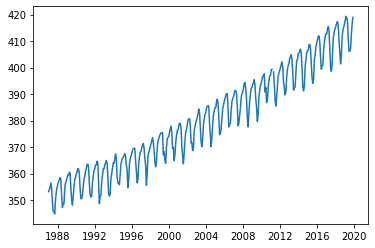

In [11]:
x = df.index
y = df['co2']
plt.plot(x, y)

In [12]:
#分析の対象と検証用に分ける
#今回は欠損値を含まない、2011年3月までを分析の対象にする
train = df[:'2011-03-01']
test = df['2011-04-01':]

In [13]:
#分析対象と検証用の割合が約3:1であることが確認できるので、前述の分割方法で適切に分析できそう
len(train)/(len(train)+len(test))

0.7348484848484849

## 分析1 成分分解

In [14]:
#必要ライブラリのインポート
import statsmodels.api as sm

In [15]:
#トレンド成分、季節成分、残差成分に分解
#加法モデル(デフォルト)
decompose_result = sm.tsa.seasonal_decompose(train, period = 12)

In [16]:
print(decompose_result.trend.head(12))
print(decompose_result.seasonal.head(12))
print(decompose_result.resid.head(12))

date
1987-01-01           NaN
1987-02-01           NaN
1987-03-01           NaN
1987-04-01           NaN
1987-05-01           NaN
1987-06-01           NaN
1987-07-01    351.491667
1987-08-01    351.729167
1987-09-01    351.966667
1987-10-01    352.166667
1987-11-01    352.387500
1987-12-01    352.612500
Name: trend, dtype: float64
date
1987-01-01    3.016650
1987-02-01    3.996722
1987-03-01    4.705418
1987-04-01    5.290744
1987-05-01    3.963932
1987-06-01   -1.871756
1987-07-01   -5.700961
1987-08-01   -8.126655
1987-09-01   -6.661724
1987-10-01   -1.711974
1987-11-01    0.923896
1987-12-01    2.175708
Name: seasonal, dtype: float64
date
1987-01-01         NaN
1987-02-01         NaN
1987-03-01         NaN
1987-04-01         NaN
1987-05-01         NaN
1987-06-01         NaN
1987-07-01    0.109294
1987-08-01    1.997488
1987-09-01   -0.504942
1987-10-01   -0.454693
1987-11-01   -0.511396
1987-12-01   -0.188208
Name: resid, dtype: float64


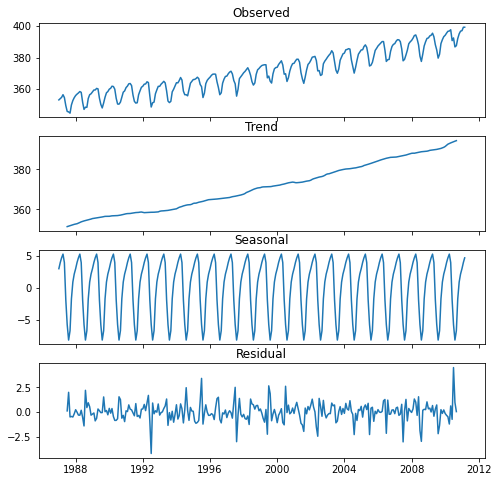

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

# 原系列
axes[0].set_title('Observed')
axes[0].plot(decompose_result.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(decompose_result.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(decompose_result.seasonal)

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(decompose_result.resid)

# グラフを表示する
plt.show()

In [18]:
#トレンドの回帰モデルへのあてはめ
trend = decompose_result.trend
trend.index = trend.reset_index(drop=True).index+1
trend

1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
       ..
287   NaN
288   NaN
289   NaN
290   NaN
291   NaN
Name: trend, Length: 291, dtype: float64

<AxesSubplot:>

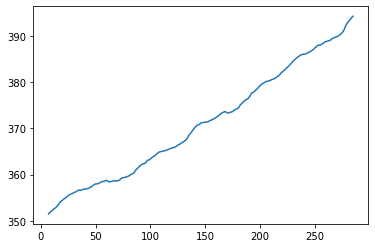

In [19]:
trend.plot()

In [20]:
#trendの最初と最後の6行は欠測値であることを踏まえて、回帰分析
x = trend.dropna().index
y = trend.dropna()

#w1は係数、w0は切片
w1, w0 = np.polyfit(x, y, 1)

mod = sm.OLS(y, sm.add_constant(x))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  trend   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 2.919e+04
Date:                Sun, 13 Mar 2022   Prob (F-statistic):          9.20e-283
Time:                        22:25:38   Log-Likelihood:                -437.17
No. Observations:                 279   AIC:                             878.3
Df Residuals:                     277   BIC:                             885.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        349.5014      0.144   2423.242      0.000     349.217     349.785
x1             0.1478      0.001    170.850      0.000       0.146       0.149
==============================================================================
Omnibus:                       46.685   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.295
Skew:                           0.273   Prob(JB):                     0.000787
Kurtosis:                       2.035   Cond. No.                         345.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
#回帰式からトレンドを予測
result_1 = df.reset_index()
result_1.index = result_1.index+1
result_1['prtrend'] =  w0 + w1*result_1.index

<AxesSubplot:>

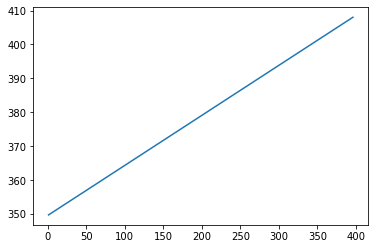

In [22]:
result_1['prtrend'].plot()

In [23]:
#trainから抽出された季節成分を、予測部分にも適用する
seasonal = list(decompose_result.seasonal.head(12)) * (-(-len(df)//12))

In [24]:
result_1['seasonal'] = seasonal[:len(result_1)]

<AxesSubplot:>

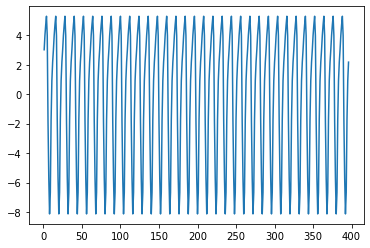

In [25]:
result_1['seasonal'].plot()

In [26]:
result_1['pred_1'] = result_1['prtrend'] + result_1['seasonal'] 

In [27]:
result_1 = result_1.set_index('date')[['prtrend', 'seasonal', 'pred_1']]

In [28]:
result_1

,prtrend,seasonal,pred_1
date,,,
1987-01-01,349.649161,3.016650,352.665811
1987-02-01,349.796943,3.996722,353.793666
1987-03-01,349.944726,4.705418,354.650144
1987-04-01,350.092508,5.290744,355.383252
1987-05-01,350.240291,3.963932,354.204223
...,...,...,...
2019-08-01,407.432091,-8.126655,399.305436
2019-09-01,407.579874,-6.661724,400.918149
2019-10-01,407.727656,-1.711974,406.015683


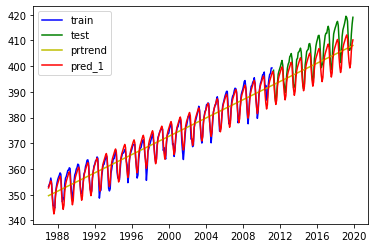

In [29]:
plt.figure()
plt.plot(train, color='b', label='train')
plt.plot(test, color='g', label='test')
plt.plot(result_1['prtrend'], color='y', label='prtrend')
plt.plot(result_1['pred_1'], color='r', label='pred_1')
plt.legend()
plt.show()

## 分析2 SARIMA

In [30]:
#自己相関関数
train_acf = sm.tsa.stattools.acf(train, nlags=40, fft = False)
print(train_acf)

#偏自己相関関数
train_pacf = sm.tsa.stattools.pacf(train, nlags=40, method='ols')
print(train_pacf)

[1.         0.96222463 0.90045131 0.83593927 0.78410504 0.75384248
 0.7390535  0.73676471 0.74922734 0.77926674 0.82405526 0.86144944
 0.87354746 0.84169746 0.78302332 0.72028282 0.67131184 0.64333687
 0.62942099 0.62883181 0.64348881 0.67501577 0.71891162 0.7561866
 0.76727899 0.73853613 0.68254877 0.62289293 0.57509933 0.5482053
 0.53473916 0.53341136 0.54752273 0.57911034 0.61904365 0.65420283
 0.66296078 0.63504178 0.5824004  0.52436619 0.47862327]
[ 1.          0.97720682 -0.46976598  0.12566027  0.22764298  0.23052328
  0.01320199  0.15325394  0.37672862  0.58948331  0.46372943  0.52198805
  0.51191339 -0.16400004 -0.20299918 -0.22766865 -0.08027175  0.0148238
  0.00317188  0.02915383 -0.05104482  0.04361247  0.04676859  0.07295256
  0.20854957 -0.00599557 -0.09016665  0.05137769 -0.07059596  0.08797101
 -0.04119016 -0.02694712  0.06248923  0.09593008  0.02419489  0.15923178
 -0.01836486  0.03912999  0.05056022 -0.15290969 -0.05889735]


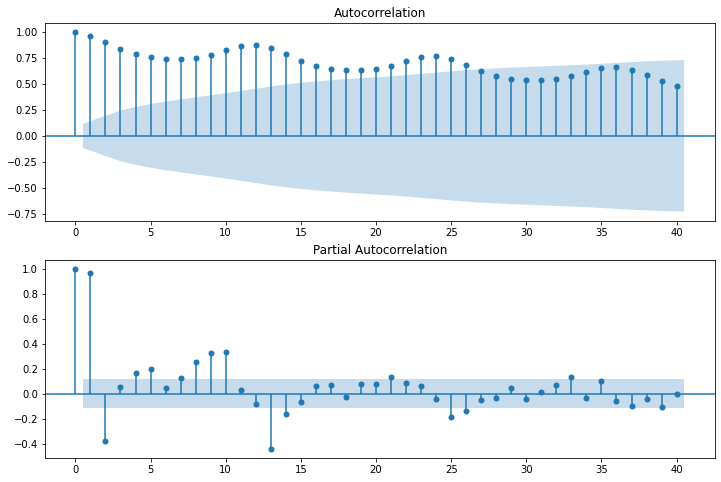

In [31]:
#自己相関のグラフ
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train, lags=40, ax=ax2)

In [32]:
import warnings
warnings.simplefilter('ignore')

In [33]:
#和分過程と推定して差分をとる
diff = train - train.shift()
diff = diff.dropna()

#差分系列への自動ARMA推定関数の実行
resDiff = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')
resDiff

{'aic':              0            1            2
 0          NaN  1422.668983  1415.722280
 1  1419.770370  1418.153423  1400.924313
 2  1414.754920  1349.156697  1260.857155
 3  1398.873952  1338.290834  1259.967138
 4  1383.885409  1336.066584  1254.218918,
 'aic_min_order': (4, 2)}

In [34]:
#ARIMAモデルの推定
#P=4, q=2 が最善となったので、それをモデル化
#真ん中の1は1階差分
from statsmodels.tsa.arima_model import ARIMA
ARIMA_4_1_2 = ARIMA(train, order=(4, 1, 2)).fit(dist=False)
ARIMA_4_1_2.params

const          0.158106
ar.L1.D.co2    1.726728
ar.L2.D.co2   -1.229680
ar.L3.D.co2    0.392536
ar.L4.D.co2   -0.203234
ma.L1.D.co2   -1.834706
ma.L2.D.co2    0.923346
dtype: float64

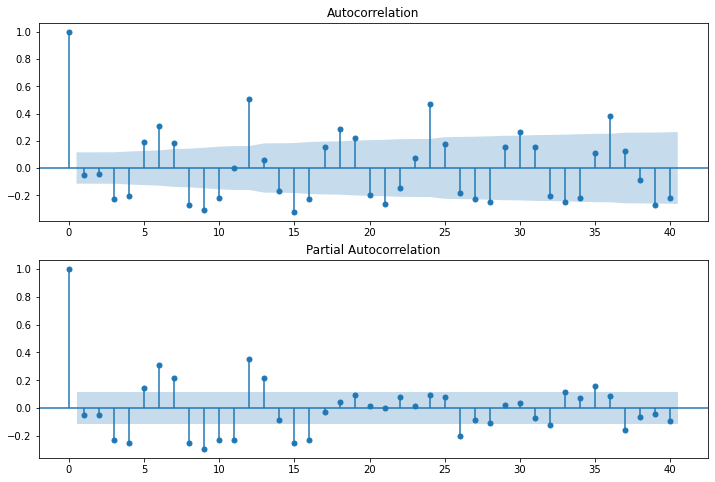

In [35]:
#残差のチェック
#SARIMAじゃないので、周期性が残っている
resid = ARIMA_4_1_2.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [ ]:
# 時間がかかるので一旦コメントアウトしている

In [36]:
# sarimaのパラメータは order=(3,1,3), seasonal_order=(1,1,1,12)でAICが最小
SARIMA_3_1_3_111 = sarima = sm.tsa.SARIMAX(
                            train, order=(3,1,3), 
                            seasonal_order=(1,1,1,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False).fit()
print(SARIMA_3_1_3_111.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  co2   No. Observations:                  291
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -417.882
Date:                              Sun, 13 Mar 2022   AIC                            853.765
Time:                                      22:25:56   BIC                            885.880
Sample:                                  01-01-1987   HQIC                           866.672
                                       - 03-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3797      0.089    -15.484      0.000      -1.554      -1.205
ar.L2         -0.89

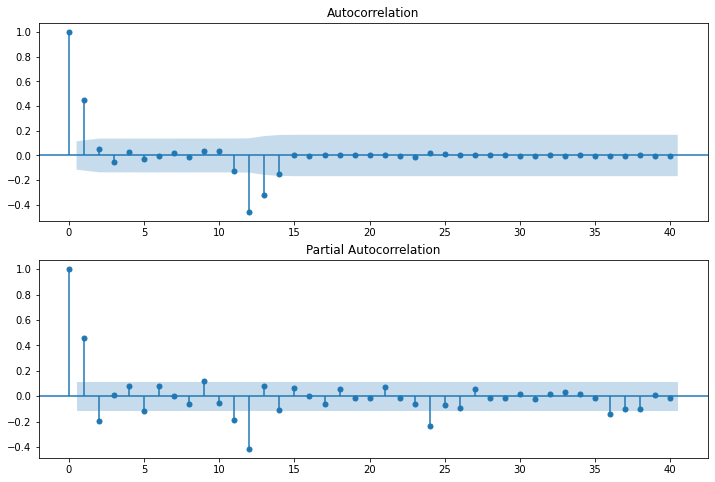

In [37]:
#残差のチェック
residSARIMA = SARIMA_3_1_3_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

In [38]:
pred_2 = SARIMA_3_1_3_111.predict('1989-03-01', '2019-12-01')

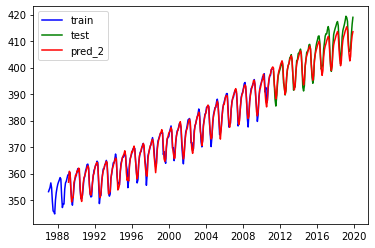

In [39]:
plt.figure()
plt.plot(train, color='b', label='train')
plt.plot(test, color='g', label='test')
plt.plot(pred_2, color='r', label='pred_2')
plt.legend()
plt.show()

## 分析3 LSTMモデル

In [40]:
#必要ライブラリのインポート
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [41]:
#正規化
from sklearn import preprocessing
mm = preprocessing.MinMaxScaler()
train_norm = mm.fit_transform(train)

In [42]:
# 入力データと教師データの作成
def make_dataset(low_data, maxlen):

    data, target = [], []

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target

In [43]:
# RNNへの入力データ数
window_size = 12*3
data, label = make_dataset(train_norm, window_size)

In [44]:
#LSTMの入力の長さ
length_of_sequence = data.shape[1]
#時系列データの単位時間における特徴量の次元数
#今回は単位時間あたり1つのスカラー量なので 1
in_out_neurons = 1
#隠れ層の次元数
n_hidden = 300

In [45]:
# ネットワークの構築
model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation('linear'))
optimizer = Adam(learning_rate=1e-3)

#コンパイル
model.compile(loss="mean_squared_error", optimizer=optimizer)

In [46]:
#過学習を防ぐ
#10エポック数の間に val_loss (テストデータに対して計算された損失値) に改善がないと，学習が停止
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=10)

In [47]:
#バッチ数は32or64とする
#学習データのうち、10％を検証データ（validation）として使用
hist = model.fit(data, label,
                 batch_size=32, epochs=200,
                 callbacks=[early_stopping],
                 validation_split=0.1)

Epoch 1/200
8/8 [==============================] - 6s 258ms/step - loss: 0.1064 - val_loss: 0.0630
Epoch 2/200
8/8 [==============================] - 1s 155ms/step - loss: 0.0263 - val_loss: 0.0175
Epoch 3/200
8/8 [==============================] - 1s 154ms/step - loss: 0.0164 - val_loss: 0.0171
Epoch 4/200
8/8 [==============================] - 1s 158ms/step - loss: 0.0129 - val_loss: 0.0250
Epoch 5/200
8/8 [==============================] - 1s 181ms/step - loss: 0.0122 - val_loss: 0.0117
Epoch 6/200
8/8 [==============================] - 1s 156ms/step - loss: 0.0117 - val_loss: 0.0157
Epoch 7/200
8/8 [==============================] - 1s 166ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 8/200
8/8 [==============================] - 1s 175ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 9/200
8/8 [==============================] - 1s 180ms/step - loss: 0.0104 - val_loss: 0.0114
Epoch 10/200
8/8 [==============================] - 1s 173ms/step - loss: 0.0103 - val_loss: 0.0104
Epoch 11/

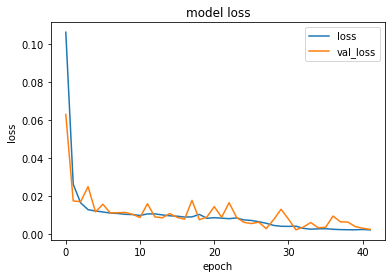

In [48]:
# 損失値(Loss)の遷移のプロット
plt.plot(hist.history['loss'],label="loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [49]:
#trainの期間の予測し、正規化したので元に戻し、リスト化
train_pred = mm.inverse_transform(model.predict(data)).reshape(1,-1)[0].tolist()

In [50]:
#未来予測（testの期間の予測）

#dataの最後尾のデータセットを取得
future_test = data[-1].T

#予測結果を保存する配列
future_result = np.empty((0))

#予測期間はtestデータの長さ分
pred_time_length = len(test)

#予測結果をfuture_resultに格納
for step in range(pred_time_length):
    test_data = np.reshape(future_test, (1, window_size, 1))
    
    #モデルによる予測
    batch_predict = model.predict(test_data)
    
    #future_testの最初の数値を削除
    future_test = np.delete(future_test, 0)
    #future_testの最後に予測結果を加える
    future_test = np.append(future_test, batch_predict)
    
    #future_resultに予測結果を加える
    future_result = np.append(future_result, batch_predict)
    
#正規化したので元に戻し、リスト化
test_pred = mm.inverse_transform(future_result.reshape(1,-1))[0].tolist()

In [51]:
result_train = train.copy()
result_train['pred_3'] = np.nan
result_train.tail(len(result_train)-window_size)['pred_3'] = train_pred

In [52]:
result_test = test.copy()
result_test['pred_3'] = test_pred

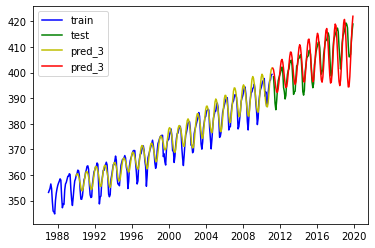

In [53]:
plt.figure()
plt.plot(result_train['co2'], color='b', label='train')
plt.plot(result_test['co2'], color='g', label='test')
#trainの期間の予測
plt.plot(result_train['pred_3'], color='y', label='pred_3')
#testの期間の予測
plt.plot(result_test['pred_3'], color='r', label='pred_3')
plt.legend()
plt.show()

## 予測結果の比較

In [54]:
predict = test.copy()

In [55]:
predict['pred_1'] = result_1['pred_1']
predict['pred_2'] = pred_2
predict['pred_3'] = result_test['pred_3']
predict = predict.sort_index(axis=1)

<AxesSubplot:xlabel='date'>

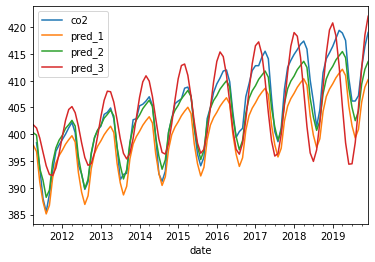

In [56]:
predict.plot()

In [57]:
predict = predict.dropna()

In [58]:
# MAEを算出
from sklearn.metrics import mean_absolute_error
mae1 = mean_absolute_error(predict['co2'], predict['pred_1'])
mae2 = mean_absolute_error(predict['co2'], predict['pred_2'])
mae3 = mean_absolute_error(predict['co2'], predict['pred_3'])
print(mae1)
print(mae2)
print(mae3)

4.271634948443118
1.8037608542250692
4.068511631683664
